In [3]:
## Baseline Model – Logistic Regression

Objective:
Train an interpretable baseline classifier on SIEM security events
to evaluate attack detection performance using SOC-relevant metrics.


SyntaxError: invalid syntax (659064535.py, line 3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
df = pd.read_csv("data/raw/cyfercode_security_events_v2.csv")
df.shape


(28220, 11)

In [3]:
df.head(5)

,event_type,src_ip_type,dst_port,protocol,alert_signature,failed_attempts,session_duration,bytes_sent,is_cloud_asset,alert_severity,label
0,firewall,internal,21,tcp,normal,1,66,47,1,low,0
1,cloud,internal,53,tcp,normal,5,209,2915,1,low,0
2,auth,internal,25,tcp,normal,2,677,11857,0,low,0
3,firewall,internal,3389,tcp,normal,3,53,2847,0,low,0
4,ids,internal,443,tcp,normal,3,70,2654,0,low,0


In [10]:
num_features = [
    "dst_port",
    "failed_attempts",
    "session_duration",
    "bytes_sent"
]

cat_features = [
    "event_type",
    "src_ip_type",
    "protocol",
    "alert_signature",
    "alert_severity",
    "is_cloud_asset"
]

target = "label"

X = df[num_features + cat_features]
y = df[target]


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [14]:
X_train.shape

(22576, 10)

In [13]:
X_test.shape

(5644, 10)

In [22]:
y_train.shape

(22576,)

In [23]:
y_test.shape

(5644,)

In [15]:
numeric_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_pipeline = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_features),
        ("cat", categorical_pipeline, cat_features)
    ]
)


In [16]:
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ]
)


In [17]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['dst_port',
                                                   'failed_attempts',
                                                   'session_duration',
                                                   'bytes_sent']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['event_type', 'src_ip_type',
                                                   'protocol',
                                                   'alert_signature',
                                                   'alert_severity',
                                                   'is_cloud_asset'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [18]:
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
coefficients = pipeline.named_steps["classifier"].coef_[0]

feature_importance = (
    pd.DataFrame({
        "feature": feature_names,
        "coefficient": coefficients,
        "abs_coefficient": np.abs(coefficients)
    })
    .sort_values("abs_coefficient", ascending=False)
)

feature_importance.head(15)


,feature,coefficient,abs_coefficient
14,cat__alert_signature_normal,-6.773502,6.773502
17,cat__alert_severity_low,-5.208308,5.208308
16,cat__alert_severity_high,3.950902,3.950902
15,cat__alert_signature_port_scan,3.266640,3.266640
13,cat__alert_signature_malware,3.113017,3.113017
8,cat__src_ip_type_external,2.453860,2.453860
18,cat__alert_severity_medium,2.212695,2.212695
0,num__dst_port,-1.520912,1.520912
9,cat__src_ip_type_internal,-1.498572,1.498572
12,cat__alert_signature_bruteforce,1.349133,1.349133


In [21]:
y_proba = pipeline.predict_proba(X_test)[:, 1]

thresholds = [0.9, 0.7,0.6, 0.5, 0.4, 0.3]
rows = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

    rows.append({
        "threshold": t,
        "attack_recall": tp / (tp + fn),
        "false_positives": fp,
        "true_positives": tp
    })

threshold_df = pd.DataFrame(rows)
threshold_df


,threshold,attack_recall,false_positives,true_positives
0,0.9,0.99115,0,1232
1,0.7,1.00000,0,1243
2,0.6,1.00000,0,1243
3,0.5,1.00000,1,1243
4,0.4,1.00000,4,1243
5,0.3,1.00000,6,1243


In [27]:
from sklearn.metrics import confusion_matrix, classification_report

# Use the already computed probabilities
THRESHOLD = 0.7
y_pred = (y_proba >= THRESHOLD).astype(int)

cm = confusion_matrix(y_test, y_pred)

print("Baseline V1 Confusion Matrix (Threshold = 0.7):")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Baseline V1 Confusion Matrix (Threshold = 0.7):
[[4401    0]
 [   0 1243]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4401
           1       1.00      1.00      1.00      1243

    accuracy                           1.00      5644
   macro avg       1.00      1.00      1.00      5644
weighted avg       1.00      1.00      1.00      5644



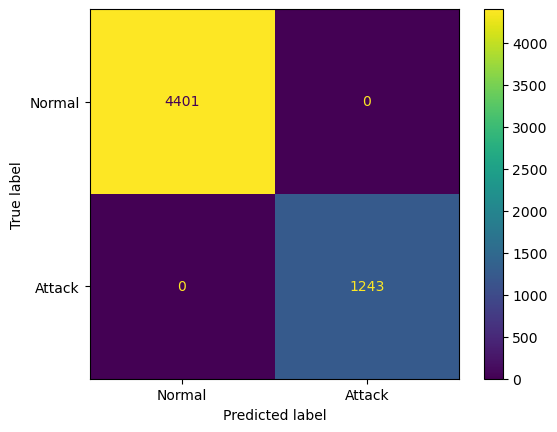

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Normal", "Attack"], values_format="d")
plt.show()

